<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase2/blob/master/EVA4P2_S7_VAE_V5_KLD_batch_imgsize_no_Sigmoid_for_encoder_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Tue Sep 22 08:20:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
import cv2
import pkgutil
import importlib
import os
import random
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML
sns.set()
print('Pytorch version:', torch.__version__)

Pytorch version: 1.5.1+cu92


In [5]:
%%time
from zipfile import ZipFile
with ZipFile('/content/gdrive/My Drive/EVA4P2_S6_Zipdataset/EVA4P2_S6_GAN_Cars_better_Size128.zip', mode='r') as input:
  input.extractall('.')

CPU times: user 39.6 ms, sys: 30.8 ms, total: 70.4 ms
Wall time: 75.6 ms


In [8]:
def prepare_data(root, classes):
  finaldata = []
  for i in range(len(classes)):
    path = root + '/' + classes[i] + '/'
    data_rec = [(path+file_name, i) for file_name in os.listdir(path)]
    finaldata.extend(data_rec) 
  random.shuffle(finaldata)
  return finaldata

In [6]:
class_list       = [0]
class_names_dict = {0:'Cars'}
class_names      = ['Cars']

In [9]:
dataset          = prepare_data('/content/Data',class_names)
print(f'Dataset Length:{len(dataset)}, Train Data length: {int(len(dataset)*1)},Test Data length: {int(len(dataset)*0)}')
train_len = int(len(dataset)*1)

Dataset Length:505, Train Data length: 505,Test Data length: 0


In [10]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase2

Cloning into 'Deep_Learning_EVA4_Phase2'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 909 (delta 47), reused 36 (delta 13), pack-reused 791
Receiving objects: 100% (909/909), 146.67 MiB | 27.98 MiB/s, done.
Resolving deltas: 100% (478/478), done.
Checking out files: 100% (159/159), done.


In [10]:
%cd '/content/Deep_Learning_EVA4_Phase2/S7_VAE'
! ls

/content/Deep_Learning_EVA4_Phase2/S7_VAE
README.md  src


In [11]:
os.chdir('/content/Deep_Learning_EVA4_Phase2/S7_VAE/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import customdataset as cds
from src.dataset import Alb_data_transforms as Alb
from src.losses  import Train_Losses
from src.losses  import Test_Losses
from src.models  import VAE_Model as ntwk

In [12]:
import albumentations as A
channel_means  = (0.48043839, 0.44820218, 0.39760034)
channel_stdevs = (0.27698959, 0.26908774, 0.28216029)
# Train Phase transformations
train_transforms = Alb.Albumentations_transform([
                                      A.Resize(128, 128),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                    ])
test_transforms  = Alb.Albumentations_transform([
                                      A.Resize(128, 128),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                    ])

In [13]:
train = cds.Customdataset(dataset[:train_len],train_transforms)
#test  = cds.Customdataset(dataset[train_len:],test_transforms)
print(f'Train Length {len(train)}') #, Test Length {len(test)}')

Train Length 505


In [14]:
train_loader  = DataLoader(train, batch_size = 32,shuffle = True, num_workers=2, pin_memory = True)
#test_loader   = DataLoader(test, batch_size = 32, shuffle = False, pin_memory = True)

In [16]:
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  #print(img.shape)
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i]) + channel_means[i]
  return np.transpose(img, (1,2,0))

In [17]:
dataiter = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

To check if images are coming out correctly as batches, images.shape: torch.Size([32, 3, 128, 128]), labels.shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

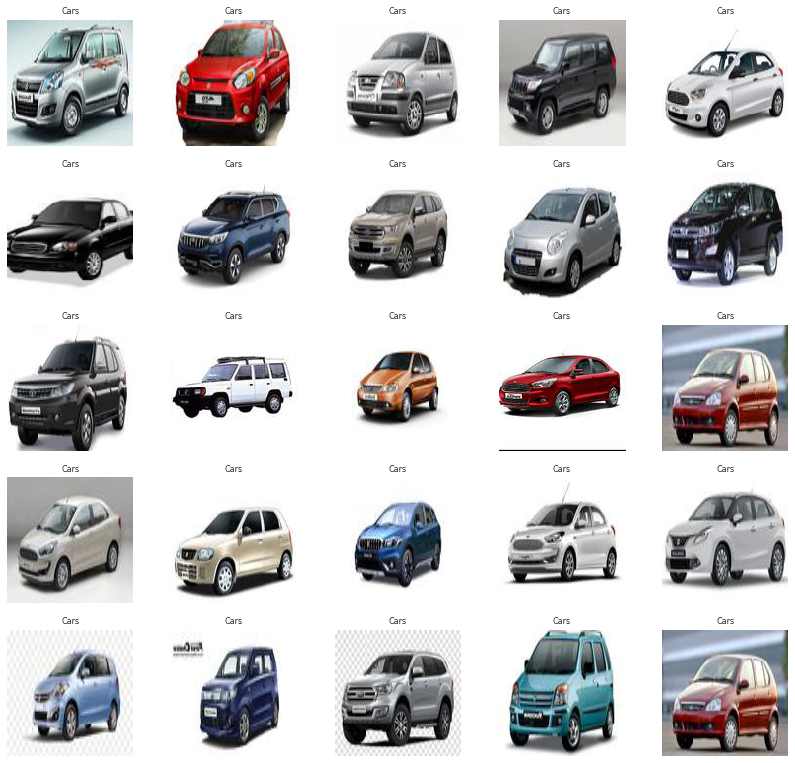

In [18]:
images, labels = dataiter.next()
print(f'To check if images are coming out correctly as batches, images.shape: {images.shape}, labels.shape: {labels.shape}')
num_classes = len(class_names)
r, c = 5, 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax  = plt.subplot(r,c, idx + 1)
    ax.set_title(class_names[labels[idx]][:30], fontdict={'fontsize':8})
    plt.axis('off')
    ax.imshow(unnormalize(images[idx]), interpolation ='none')
plt.show() 

In [15]:
IMAGE_DIM = (128, 128, 3)

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")
VAE_Model = ntwk.VAE(IMAGE_DIM, in_channel=IMAGE_DIM[-1],out_channel=IMAGE_DIM[-1]).to(DEVICE)
VAE_Model.apply(weights_init)
print('Model Defined')

Model Defined


In [18]:
!pip install torchsummary
from torchsummary import summary

In [19]:
summary(VAE_Model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 64, 64]          13,824
       BatchNorm2d-2          [-1, 512, 64, 64]           1,024
              ReLU-3          [-1, 512, 64, 64]               0
            Conv2d-4          [-1, 256, 32, 32]       1,179,648
       BatchNorm2d-5          [-1, 256, 32, 32]             512
              ReLU-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]         294,912
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 128, 8, 8]         147,456
      BatchNorm2d-11            [-1, 128, 8, 8]             256
             ReLU-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 128, 4, 4]         147,456
      BatchNorm2d-14            [-1, 12

In [20]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_Losses.Test_loss()

In [21]:
criterion = nn.MSELoss()
VAE_Model_opt = torch.optim.Adam(VAE_Model.parameters(), lr=0.001, betas=(0.5, 0.999))
max_epoch  = 1500
batch_size = 32
img_anim_list, train_loss_all, test_loss_all = [], [], []

In [22]:
VAE_prev_save = f'/content/gdrive/My Drive/EVA4P2_S7_Training/Model_Weights_D0920/VAE_GPU_499_20200922043600.pt'
VAE_Model.load_state_dict(torch.load(VAE_prev_save))

<All keys matched successfully>

In [23]:
for epoch in range(max_epoch):

    train_losses,img_list = train_loss.train_loss_calc(VAE_Model,DEVICE,train_loader=train_loader,optimizer=VAE_Model_opt,
                                                       epoch=epoch, max_epoch= max_epoch, criterion=criterion)                                                       
    #test_losses           = test_loss.test_loss_calc(VAE_Model,DEVICE,test_loader=test_loader,optimizer=VAE_Model_opt,
    #                                                   epoch=epoch, max_epoch= max_epoch,criterion=criterion)   

    if len(img_list) > 0:
        img_anim_list.extend(img_list)                                          

    train_loss_all.append(train_losses)
    #test_loss_all.append(test_losses)
    print(f'Monitoring...Epoch: {epoch+1}/{max_epoch},   Train Loss: {train_losses:.6f}') #, Test Loss: {test_losses:.6f}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-18 Saved - Epoch: 1/1500, Train Loss: 0.762555, batch_idx:14
GPU model saved in epoch 1/1500, batch_idx:14
Monitoring...Epoch: 1/1500,   Train Loss: 0.742369
Monitoring...Epoch: 2/1500,   Train Loss: 0.731815
Monitoring...Epoch: 3/1500,   Train Loss: 0.785137
Monitoring...Epoch: 4/1500,   Train Loss: 0.781175
Monitoring...Epoch: 5/1500,   Train Loss: 0.743459
Monitoring...Epoch: 6/1500,   Train Loss: 0.783429
Monitoring...Epoch: 7/1500,   Train Loss: 0.798937
Monitoring...Epoch: 8/1500,   Train Loss: 0.734305
Monitoring...Epoch: 9/1500,   Train Loss: 0.758088
Monitoring...Epoch: 10/1500,   Train Loss: 0.773664
Monitoring...Epoch: 11/1500,   Train Loss: 0.823392
Monitoring...Epoch: 12/1500,   Train Loss: 0.767935
Monitoring...Epoch: 13/1500,   Train Loss: 0.749419
Monitoring...Epoch: 14/1500,   Train Loss: 0.783710
Monitoring...Epoch: 15/1500,   Train Loss: 0.799084
Monitoring...Epoch: 16/1500,   Train Loss: 0.759537
Monitoring...Epoch: 17/1500,   Train Loss: 0.773152
Moni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-25 Saved - Epoch: 31/1500, Train Loss: 0.742272, batch_idx:14
Monitoring...Epoch: 31/1500,   Train Loss: 0.711226
Monitoring...Epoch: 32/1500,   Train Loss: 0.756939
Monitoring...Epoch: 33/1500,   Train Loss: 0.742133
Monitoring...Epoch: 34/1500,   Train Loss: 0.762354
Monitoring...Epoch: 35/1500,   Train Loss: 0.803318
Monitoring...Epoch: 36/1500,   Train Loss: 0.813289
Monitoring...Epoch: 37/1500,   Train Loss: 0.763341
Monitoring...Epoch: 38/1500,   Train Loss: 0.828285
Monitoring...Epoch: 39/1500,   Train Loss: 0.779028
Monitoring...Epoch: 40/1500,   Train Loss: 0.794388
Monitoring...Epoch: 41/1500,   Train Loss: 0.767433
Monitoring...Epoch: 42/1500,   Train Loss: 0.706068
Monitoring...Epoch: 43/1500,   Train Loss: 0.797430
Monitoring...Epoch: 44/1500,   Train Loss: 0.711520
Monitoring...Epoch: 45/1500,   Train Loss: 0.815592
GPU model saved in epoch 46/1500, batch_idx:14
Monitoring...Epoch: 46/1500,   Train Loss: 0.750958
Monitoring...Epoch: 47/1500,   Train Loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-28 Saved - Epoch: 61/1500, Train Loss: 0.787519, batch_idx:14
Monitoring...Epoch: 61/1500,   Train Loss: 0.726312
Monitoring...Epoch: 62/1500,   Train Loss: 0.775411
Monitoring...Epoch: 63/1500,   Train Loss: 0.743913
Monitoring...Epoch: 64/1500,   Train Loss: 0.745360
Monitoring...Epoch: 65/1500,   Train Loss: 0.818230
Monitoring...Epoch: 66/1500,   Train Loss: 0.747766
Monitoring...Epoch: 67/1500,   Train Loss: 0.750730
Monitoring...Epoch: 68/1500,   Train Loss: 0.759579
Monitoring...Epoch: 69/1500,   Train Loss: 0.795322
Monitoring...Epoch: 70/1500,   Train Loss: 0.788641
Monitoring...Epoch: 71/1500,   Train Loss: 0.786994
Monitoring...Epoch: 72/1500,   Train Loss: 0.733464
Monitoring...Epoch: 73/1500,   Train Loss: 0.727198
Monitoring...Epoch: 74/1500,   Train Loss: 0.833628
Monitoring...Epoch: 75/1500,   Train Loss: 0.759582
Monitoring...Epoch: 76/1500,   Train Loss: 0.721099
Monitoring...Epoch: 77/1500,   Train Loss: 0.772463
Monitoring...Epoch: 78/1500,   Train Los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-23 Saved - Epoch: 91/1500, Train Loss: 0.781008, batch_idx:14
GPU model saved in epoch 91/1500, batch_idx:14
Monitoring...Epoch: 91/1500,   Train Loss: 0.753117
Monitoring...Epoch: 92/1500,   Train Loss: 0.721643
Monitoring...Epoch: 93/1500,   Train Loss: 0.754530
Monitoring...Epoch: 94/1500,   Train Loss: 0.807792
Monitoring...Epoch: 95/1500,   Train Loss: 0.782237
Monitoring...Epoch: 96/1500,   Train Loss: 0.739828
Monitoring...Epoch: 97/1500,   Train Loss: 0.789311
Monitoring...Epoch: 98/1500,   Train Loss: 0.768507
Monitoring...Epoch: 99/1500,   Train Loss: 0.814748
Monitoring...Epoch: 100/1500,   Train Loss: 0.788801
Monitoring...Epoch: 101/1500,   Train Loss: 0.781350
Monitoring...Epoch: 102/1500,   Train Loss: 0.765511
Monitoring...Epoch: 103/1500,   Train Loss: 0.759196
Monitoring...Epoch: 104/1500,   Train Loss: 0.727110
Monitoring...Epoch: 105/1500,   Train Loss: 0.736803
Monitoring...Epoch: 106/1500,   Train Loss: 0.687010
Monitoring...Epoch: 107/1500,   Train 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-8 Saved - Epoch: 121/1500, Train Loss: 0.742405, batch_idx:14
Monitoring...Epoch: 121/1500,   Train Loss: 0.757283
Monitoring...Epoch: 122/1500,   Train Loss: 0.745213
Monitoring...Epoch: 123/1500,   Train Loss: 0.733378
Monitoring...Epoch: 124/1500,   Train Loss: 0.771481
Monitoring...Epoch: 125/1500,   Train Loss: 0.775303
Monitoring...Epoch: 126/1500,   Train Loss: 0.741163
Monitoring...Epoch: 127/1500,   Train Loss: 0.768362
Monitoring...Epoch: 128/1500,   Train Loss: 0.787566
Monitoring...Epoch: 129/1500,   Train Loss: 0.767125
Monitoring...Epoch: 130/1500,   Train Loss: 0.749860
Monitoring...Epoch: 131/1500,   Train Loss: 0.813702
Monitoring...Epoch: 132/1500,   Train Loss: 0.751203
Monitoring...Epoch: 133/1500,   Train Loss: 0.715262
Monitoring...Epoch: 134/1500,   Train Loss: 0.778245
Monitoring...Epoch: 135/1500,   Train Loss: 0.728349
GPU model saved in epoch 136/1500, batch_idx:14
Monitoring...Epoch: 136/1500,   Train Loss: 0.748590
Monitoring...Epoch: 137/1500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-19 Saved - Epoch: 151/1500, Train Loss: 0.732717, batch_idx:14
Monitoring...Epoch: 151/1500,   Train Loss: 0.730756
Monitoring...Epoch: 152/1500,   Train Loss: 0.773736
Monitoring...Epoch: 153/1500,   Train Loss: 0.751765
Monitoring...Epoch: 154/1500,   Train Loss: 0.723380
Monitoring...Epoch: 155/1500,   Train Loss: 0.823420
Monitoring...Epoch: 156/1500,   Train Loss: 0.776351
Monitoring...Epoch: 157/1500,   Train Loss: 0.766558
Monitoring...Epoch: 158/1500,   Train Loss: 0.756156
Monitoring...Epoch: 159/1500,   Train Loss: 0.791479
Monitoring...Epoch: 160/1500,   Train Loss: 0.772974
Monitoring...Epoch: 161/1500,   Train Loss: 0.761233
Monitoring...Epoch: 162/1500,   Train Loss: 0.790913
Monitoring...Epoch: 163/1500,   Train Loss: 0.713637
Monitoring...Epoch: 164/1500,   Train Loss: 0.787323
Monitoring...Epoch: 165/1500,   Train Loss: 0.739526
Monitoring...Epoch: 166/1500,   Train Loss: 0.734845
Monitoring...Epoch: 167/1500,   Train Loss: 0.684705
Monitoring...Epoch: 16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-11 Saved - Epoch: 181/1500, Train Loss: 0.750306, batch_idx:14
GPU model saved in epoch 181/1500, batch_idx:14
Monitoring...Epoch: 181/1500,   Train Loss: 0.741264
Monitoring...Epoch: 182/1500,   Train Loss: 0.804461
Monitoring...Epoch: 183/1500,   Train Loss: 0.817585
Monitoring...Epoch: 184/1500,   Train Loss: 0.823860
Monitoring...Epoch: 185/1500,   Train Loss: 0.800269
Monitoring...Epoch: 186/1500,   Train Loss: 0.756029
Monitoring...Epoch: 187/1500,   Train Loss: 0.775484
Monitoring...Epoch: 188/1500,   Train Loss: 0.704946
Monitoring...Epoch: 189/1500,   Train Loss: 0.802732
Monitoring...Epoch: 190/1500,   Train Loss: 0.778937
Monitoring...Epoch: 191/1500,   Train Loss: 0.750793
Monitoring...Epoch: 192/1500,   Train Loss: 0.700394
Monitoring...Epoch: 193/1500,   Train Loss: 0.782004
Monitoring...Epoch: 194/1500,   Train Loss: 0.770986
Monitoring...Epoch: 195/1500,   Train Loss: 0.763792
Monitoring...Epoch: 196/1500,   Train Loss: 0.761735
Monitoring...Epoch: 197/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-29 Saved - Epoch: 211/1500, Train Loss: 0.778312, batch_idx:14
Monitoring...Epoch: 211/1500,   Train Loss: 0.722152
Monitoring...Epoch: 212/1500,   Train Loss: 0.758058
Monitoring...Epoch: 213/1500,   Train Loss: 0.738901
Monitoring...Epoch: 214/1500,   Train Loss: 0.702975
Monitoring...Epoch: 215/1500,   Train Loss: 0.669677
Monitoring...Epoch: 216/1500,   Train Loss: 0.724802
Monitoring...Epoch: 217/1500,   Train Loss: 0.746109
Monitoring...Epoch: 218/1500,   Train Loss: 0.818318
Monitoring...Epoch: 219/1500,   Train Loss: 0.808070
Monitoring...Epoch: 220/1500,   Train Loss: 0.720759
Monitoring...Epoch: 221/1500,   Train Loss: 0.744895
Monitoring...Epoch: 222/1500,   Train Loss: 0.788762
Monitoring...Epoch: 223/1500,   Train Loss: 0.804440
Monitoring...Epoch: 224/1500,   Train Loss: 0.780657
Monitoring...Epoch: 225/1500,   Train Loss: 0.797429
GPU model saved in epoch 226/1500, batch_idx:14
Monitoring...Epoch: 226/1500,   Train Loss: 0.776361
Monitoring...Epoch: 227/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-21 Saved - Epoch: 241/1500, Train Loss: 0.746279, batch_idx:14
Monitoring...Epoch: 241/1500,   Train Loss: 0.724638
Monitoring...Epoch: 242/1500,   Train Loss: 0.780064
Monitoring...Epoch: 243/1500,   Train Loss: 0.777069
Monitoring...Epoch: 244/1500,   Train Loss: 0.766532
Monitoring...Epoch: 245/1500,   Train Loss: 0.779001
Monitoring...Epoch: 246/1500,   Train Loss: 0.717846
Monitoring...Epoch: 247/1500,   Train Loss: 0.704053
Monitoring...Epoch: 248/1500,   Train Loss: 0.733867
Monitoring...Epoch: 249/1500,   Train Loss: 0.744488
Monitoring...Epoch: 250/1500,   Train Loss: 0.749040
Monitoring...Epoch: 251/1500,   Train Loss: 0.851475
Monitoring...Epoch: 252/1500,   Train Loss: 0.761377
Monitoring...Epoch: 253/1500,   Train Loss: 0.769415
Monitoring...Epoch: 254/1500,   Train Loss: 0.766890
Monitoring...Epoch: 255/1500,   Train Loss: 0.818325
Monitoring...Epoch: 256/1500,   Train Loss: 0.739221
Monitoring...Epoch: 257/1500,   Train Loss: 0.705598
Monitoring...Epoch: 25

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-3 Saved - Epoch: 271/1500, Train Loss: 0.698202, batch_idx:14
GPU model saved in epoch 271/1500, batch_idx:14
Monitoring...Epoch: 271/1500,   Train Loss: 0.728453
Monitoring...Epoch: 272/1500,   Train Loss: 0.698096
Monitoring...Epoch: 273/1500,   Train Loss: 0.783786
Monitoring...Epoch: 274/1500,   Train Loss: 0.787515
Monitoring...Epoch: 275/1500,   Train Loss: 0.749492
Monitoring...Epoch: 276/1500,   Train Loss: 0.794058
Monitoring...Epoch: 277/1500,   Train Loss: 0.761101
Monitoring...Epoch: 278/1500,   Train Loss: 0.785266
Monitoring...Epoch: 279/1500,   Train Loss: 0.764760
Monitoring...Epoch: 280/1500,   Train Loss: 0.831064
Monitoring...Epoch: 281/1500,   Train Loss: 0.779573
Monitoring...Epoch: 282/1500,   Train Loss: 0.729742
Monitoring...Epoch: 283/1500,   Train Loss: 0.792788
Monitoring...Epoch: 284/1500,   Train Loss: 0.773068
Monitoring...Epoch: 285/1500,   Train Loss: 0.715088
Monitoring...Epoch: 286/1500,   Train Loss: 0.731168
Monitoring...Epoch: 287/1500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-1 Saved - Epoch: 301/1500, Train Loss: 0.768171, batch_idx:14
Monitoring...Epoch: 301/1500,   Train Loss: 0.748744
Monitoring...Epoch: 302/1500,   Train Loss: 0.732771
Monitoring...Epoch: 303/1500,   Train Loss: 0.742845
Monitoring...Epoch: 304/1500,   Train Loss: 0.782696
Monitoring...Epoch: 305/1500,   Train Loss: 0.724813
Monitoring...Epoch: 306/1500,   Train Loss: 0.783733
Monitoring...Epoch: 307/1500,   Train Loss: 0.811106
Monitoring...Epoch: 308/1500,   Train Loss: 0.809818
Monitoring...Epoch: 309/1500,   Train Loss: 0.773644
Monitoring...Epoch: 310/1500,   Train Loss: 0.764364
Monitoring...Epoch: 311/1500,   Train Loss: 0.768134
Monitoring...Epoch: 312/1500,   Train Loss: 0.740742
Monitoring...Epoch: 313/1500,   Train Loss: 0.734370
Monitoring...Epoch: 314/1500,   Train Loss: 0.737150
Monitoring...Epoch: 315/1500,   Train Loss: 0.759031
GPU model saved in epoch 316/1500, batch_idx:14
Monitoring...Epoch: 316/1500,   Train Loss: 0.740742
Monitoring...Epoch: 317/1500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-18 Saved - Epoch: 331/1500, Train Loss: 0.710550, batch_idx:14
Monitoring...Epoch: 331/1500,   Train Loss: 0.831715
Monitoring...Epoch: 332/1500,   Train Loss: 0.755116
Monitoring...Epoch: 333/1500,   Train Loss: 0.821475
Monitoring...Epoch: 334/1500,   Train Loss: 0.740238
Monitoring...Epoch: 335/1500,   Train Loss: 0.755294
Monitoring...Epoch: 336/1500,   Train Loss: 0.805989
Monitoring...Epoch: 337/1500,   Train Loss: 0.747808
Monitoring...Epoch: 338/1500,   Train Loss: 0.810828
Monitoring...Epoch: 339/1500,   Train Loss: 0.792195
Monitoring...Epoch: 340/1500,   Train Loss: 0.719054
Monitoring...Epoch: 341/1500,   Train Loss: 0.743390
Monitoring...Epoch: 342/1500,   Train Loss: 0.743336
Monitoring...Epoch: 343/1500,   Train Loss: 0.746918
Monitoring...Epoch: 344/1500,   Train Loss: 0.755046
Monitoring...Epoch: 345/1500,   Train Loss: 0.736350
Monitoring...Epoch: 346/1500,   Train Loss: 0.691341
Monitoring...Epoch: 347/1500,   Train Loss: 0.760011
Monitoring...Epoch: 34

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-18 Saved - Epoch: 361/1500, Train Loss: 0.762472, batch_idx:14
GPU model saved in epoch 361/1500, batch_idx:14
Monitoring...Epoch: 361/1500,   Train Loss: 0.755547
Monitoring...Epoch: 362/1500,   Train Loss: 0.778351
Monitoring...Epoch: 363/1500,   Train Loss: 0.817150
Monitoring...Epoch: 364/1500,   Train Loss: 0.800726
Monitoring...Epoch: 365/1500,   Train Loss: 0.707522
Monitoring...Epoch: 366/1500,   Train Loss: 0.725368
Monitoring...Epoch: 367/1500,   Train Loss: 0.785421
Monitoring...Epoch: 368/1500,   Train Loss: 0.801541
Monitoring...Epoch: 369/1500,   Train Loss: 0.718993
Monitoring...Epoch: 370/1500,   Train Loss: 0.825971
Monitoring...Epoch: 371/1500,   Train Loss: 0.796687
Monitoring...Epoch: 372/1500,   Train Loss: 0.683916
Monitoring...Epoch: 373/1500,   Train Loss: 0.780195
Monitoring...Epoch: 374/1500,   Train Loss: 0.681318
Monitoring...Epoch: 375/1500,   Train Loss: 0.785635
Monitoring...Epoch: 376/1500,   Train Loss: 0.844263
Monitoring...Epoch: 377/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-17 Saved - Epoch: 391/1500, Train Loss: 0.757975, batch_idx:14
Monitoring...Epoch: 391/1500,   Train Loss: 0.704072
Monitoring...Epoch: 392/1500,   Train Loss: 0.729515
Monitoring...Epoch: 393/1500,   Train Loss: 0.797816
Monitoring...Epoch: 394/1500,   Train Loss: 0.799769
Monitoring...Epoch: 395/1500,   Train Loss: 0.812882
Monitoring...Epoch: 396/1500,   Train Loss: 0.714238
Monitoring...Epoch: 397/1500,   Train Loss: 0.791147
Monitoring...Epoch: 398/1500,   Train Loss: 0.765640
Monitoring...Epoch: 399/1500,   Train Loss: 0.700828
Monitoring...Epoch: 400/1500,   Train Loss: 0.745773
Monitoring...Epoch: 401/1500,   Train Loss: 0.731399
Monitoring...Epoch: 402/1500,   Train Loss: 0.779373
Monitoring...Epoch: 403/1500,   Train Loss: 0.735755
Monitoring...Epoch: 404/1500,   Train Loss: 0.736360
Monitoring...Epoch: 405/1500,   Train Loss: 0.775269
GPU model saved in epoch 406/1500, batch_idx:14
Monitoring...Epoch: 406/1500,   Train Loss: 0.788077
Monitoring...Epoch: 407/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-27 Saved - Epoch: 421/1500, Train Loss: 0.745168, batch_idx:14
Monitoring...Epoch: 421/1500,   Train Loss: 0.788765
Monitoring...Epoch: 422/1500,   Train Loss: 0.706459
Monitoring...Epoch: 423/1500,   Train Loss: 0.795447
Monitoring...Epoch: 424/1500,   Train Loss: 0.727872
Monitoring...Epoch: 425/1500,   Train Loss: 0.746694
Monitoring...Epoch: 426/1500,   Train Loss: 0.763978
Monitoring...Epoch: 427/1500,   Train Loss: 0.820909
Monitoring...Epoch: 428/1500,   Train Loss: 0.750706
Monitoring...Epoch: 429/1500,   Train Loss: 0.778530
Monitoring...Epoch: 430/1500,   Train Loss: 0.760124
Monitoring...Epoch: 431/1500,   Train Loss: 0.808039
Monitoring...Epoch: 432/1500,   Train Loss: 0.788542
Monitoring...Epoch: 433/1500,   Train Loss: 0.786810
Monitoring...Epoch: 434/1500,   Train Loss: 0.808240
Monitoring...Epoch: 435/1500,   Train Loss: 0.741278
Monitoring...Epoch: 436/1500,   Train Loss: 0.705272
Monitoring...Epoch: 437/1500,   Train Loss: 0.788269
Monitoring...Epoch: 43

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-27 Saved - Epoch: 451/1500, Train Loss: 0.737874, batch_idx:14
GPU model saved in epoch 451/1500, batch_idx:14
Monitoring...Epoch: 451/1500,   Train Loss: 0.801691
Monitoring...Epoch: 452/1500,   Train Loss: 0.660518
Monitoring...Epoch: 453/1500,   Train Loss: 0.739363
Monitoring...Epoch: 454/1500,   Train Loss: 0.758596
Monitoring...Epoch: 455/1500,   Train Loss: 0.759127
Monitoring...Epoch: 456/1500,   Train Loss: 0.781007
Monitoring...Epoch: 457/1500,   Train Loss: 0.840170
Monitoring...Epoch: 458/1500,   Train Loss: 0.777677
Monitoring...Epoch: 459/1500,   Train Loss: 0.727291
Monitoring...Epoch: 460/1500,   Train Loss: 0.776581
Monitoring...Epoch: 461/1500,   Train Loss: 0.763773
Monitoring...Epoch: 462/1500,   Train Loss: 0.779510
Monitoring...Epoch: 463/1500,   Train Loss: 0.755784
Monitoring...Epoch: 464/1500,   Train Loss: 0.760898
Monitoring...Epoch: 465/1500,   Train Loss: 0.741519
Monitoring...Epoch: 466/1500,   Train Loss: 0.767003
Monitoring...Epoch: 467/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-13 Saved - Epoch: 481/1500, Train Loss: 0.774119, batch_idx:14
Monitoring...Epoch: 481/1500,   Train Loss: 0.728913
Monitoring...Epoch: 482/1500,   Train Loss: 0.725332
Monitoring...Epoch: 483/1500,   Train Loss: 0.793098
Monitoring...Epoch: 484/1500,   Train Loss: 0.762479
Monitoring...Epoch: 485/1500,   Train Loss: 0.792448
Monitoring...Epoch: 486/1500,   Train Loss: 0.764514
Monitoring...Epoch: 487/1500,   Train Loss: 0.712857
Monitoring...Epoch: 488/1500,   Train Loss: 0.712539
Monitoring...Epoch: 489/1500,   Train Loss: 0.719708
Monitoring...Epoch: 490/1500,   Train Loss: 0.787255
Monitoring...Epoch: 491/1500,   Train Loss: 0.777623
Monitoring...Epoch: 492/1500,   Train Loss: 0.791412
Monitoring...Epoch: 493/1500,   Train Loss: 0.706169
Monitoring...Epoch: 494/1500,   Train Loss: 0.695792
Monitoring...Epoch: 495/1500,   Train Loss: 0.784193
GPU model saved in epoch 496/1500, batch_idx:14
Monitoring...Epoch: 496/1500,   Train Loss: 0.797503
Monitoring...Epoch: 497/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-20 Saved - Epoch: 511/1500, Train Loss: 0.738477, batch_idx:14
Monitoring...Epoch: 511/1500,   Train Loss: 0.752890
Monitoring...Epoch: 512/1500,   Train Loss: 0.769088
Monitoring...Epoch: 513/1500,   Train Loss: 0.717604
Monitoring...Epoch: 514/1500,   Train Loss: 0.817923
Monitoring...Epoch: 515/1500,   Train Loss: 0.723053
Monitoring...Epoch: 516/1500,   Train Loss: 0.780836
Monitoring...Epoch: 517/1500,   Train Loss: 0.777721
Monitoring...Epoch: 518/1500,   Train Loss: 0.817652
Monitoring...Epoch: 519/1500,   Train Loss: 0.765410
Monitoring...Epoch: 520/1500,   Train Loss: 0.760536
Monitoring...Epoch: 521/1500,   Train Loss: 0.789504
Monitoring...Epoch: 522/1500,   Train Loss: 0.732809
Monitoring...Epoch: 523/1500,   Train Loss: 0.783116
Monitoring...Epoch: 524/1500,   Train Loss: 0.750239
Monitoring...Epoch: 525/1500,   Train Loss: 0.719694
Monitoring...Epoch: 526/1500,   Train Loss: 0.801205
Monitoring...Epoch: 527/1500,   Train Loss: 0.751738
Monitoring...Epoch: 52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-24 Saved - Epoch: 541/1500, Train Loss: 0.778793, batch_idx:14
GPU model saved in epoch 541/1500, batch_idx:14
Monitoring...Epoch: 541/1500,   Train Loss: 0.750613
Monitoring...Epoch: 542/1500,   Train Loss: 0.854304
Monitoring...Epoch: 543/1500,   Train Loss: 0.779163
Monitoring...Epoch: 544/1500,   Train Loss: 0.810932
Monitoring...Epoch: 545/1500,   Train Loss: 0.816442
Monitoring...Epoch: 546/1500,   Train Loss: 0.769725
Monitoring...Epoch: 547/1500,   Train Loss: 0.748407
Monitoring...Epoch: 548/1500,   Train Loss: 0.752136
Monitoring...Epoch: 549/1500,   Train Loss: 0.796698
Monitoring...Epoch: 550/1500,   Train Loss: 0.722537
Monitoring...Epoch: 551/1500,   Train Loss: 0.779934
Monitoring...Epoch: 552/1500,   Train Loss: 0.763266
Monitoring...Epoch: 553/1500,   Train Loss: 0.784933
Monitoring...Epoch: 554/1500,   Train Loss: 0.689373
Monitoring...Epoch: 555/1500,   Train Loss: 0.815708
Monitoring...Epoch: 556/1500,   Train Loss: 0.780699
Monitoring...Epoch: 557/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-13 Saved - Epoch: 571/1500, Train Loss: 0.741606, batch_idx:14
Monitoring...Epoch: 571/1500,   Train Loss: 0.825518
Monitoring...Epoch: 572/1500,   Train Loss: 0.757205
Monitoring...Epoch: 573/1500,   Train Loss: 0.747792
Monitoring...Epoch: 574/1500,   Train Loss: 0.716339
Monitoring...Epoch: 575/1500,   Train Loss: 0.737557
Monitoring...Epoch: 576/1500,   Train Loss: 0.714103
Monitoring...Epoch: 577/1500,   Train Loss: 0.793118
Monitoring...Epoch: 578/1500,   Train Loss: 0.773144
Monitoring...Epoch: 579/1500,   Train Loss: 0.756670
Monitoring...Epoch: 580/1500,   Train Loss: 0.756430
Monitoring...Epoch: 581/1500,   Train Loss: 0.759135
Monitoring...Epoch: 582/1500,   Train Loss: 0.785759
Monitoring...Epoch: 583/1500,   Train Loss: 0.754360
Monitoring...Epoch: 584/1500,   Train Loss: 0.715308
Monitoring...Epoch: 585/1500,   Train Loss: 0.816615
GPU model saved in epoch 586/1500, batch_idx:14
Monitoring...Epoch: 586/1500,   Train Loss: 0.790397
Monitoring...Epoch: 587/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-16 Saved - Epoch: 601/1500, Train Loss: 0.796693, batch_idx:14
Monitoring...Epoch: 601/1500,   Train Loss: 0.765447
Monitoring...Epoch: 602/1500,   Train Loss: 0.805326
Monitoring...Epoch: 603/1500,   Train Loss: 0.773554
Monitoring...Epoch: 604/1500,   Train Loss: 0.737601
Monitoring...Epoch: 605/1500,   Train Loss: 0.775585
Monitoring...Epoch: 606/1500,   Train Loss: 0.794473
Monitoring...Epoch: 607/1500,   Train Loss: 0.776046
Monitoring...Epoch: 608/1500,   Train Loss: 0.789696
Monitoring...Epoch: 609/1500,   Train Loss: 0.735939
Monitoring...Epoch: 610/1500,   Train Loss: 0.673643
Monitoring...Epoch: 611/1500,   Train Loss: 0.794150
Monitoring...Epoch: 612/1500,   Train Loss: 0.765632
Monitoring...Epoch: 613/1500,   Train Loss: 0.741385
Monitoring...Epoch: 614/1500,   Train Loss: 0.713249
Monitoring...Epoch: 615/1500,   Train Loss: 0.792860
Monitoring...Epoch: 616/1500,   Train Loss: 0.804388
Monitoring...Epoch: 617/1500,   Train Loss: 0.753492
Monitoring...Epoch: 61

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-26 Saved - Epoch: 631/1500, Train Loss: 0.725146, batch_idx:14
GPU model saved in epoch 631/1500, batch_idx:14
Monitoring...Epoch: 631/1500,   Train Loss: 0.754801
Monitoring...Epoch: 632/1500,   Train Loss: 0.756866
Monitoring...Epoch: 633/1500,   Train Loss: 0.715934
Monitoring...Epoch: 634/1500,   Train Loss: 0.757007
Monitoring...Epoch: 635/1500,   Train Loss: 0.721842
Monitoring...Epoch: 636/1500,   Train Loss: 0.780479
Monitoring...Epoch: 637/1500,   Train Loss: 0.799495
Monitoring...Epoch: 638/1500,   Train Loss: 0.801472
Monitoring...Epoch: 639/1500,   Train Loss: 0.739273
Monitoring...Epoch: 640/1500,   Train Loss: 0.720148
Monitoring...Epoch: 641/1500,   Train Loss: 0.770062
Monitoring...Epoch: 642/1500,   Train Loss: 0.749014
Monitoring...Epoch: 643/1500,   Train Loss: 0.736100
Monitoring...Epoch: 644/1500,   Train Loss: 0.711424
Monitoring...Epoch: 645/1500,   Train Loss: 0.745677
Monitoring...Epoch: 646/1500,   Train Loss: 0.733331
Monitoring...Epoch: 647/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-27 Saved - Epoch: 661/1500, Train Loss: 0.792685, batch_idx:14
Monitoring...Epoch: 661/1500,   Train Loss: 0.750935
Monitoring...Epoch: 662/1500,   Train Loss: 0.781740
Monitoring...Epoch: 663/1500,   Train Loss: 0.756870
Monitoring...Epoch: 664/1500,   Train Loss: 0.746887
Monitoring...Epoch: 665/1500,   Train Loss: 0.735344
Monitoring...Epoch: 666/1500,   Train Loss: 0.713381
Monitoring...Epoch: 667/1500,   Train Loss: 0.741434
Monitoring...Epoch: 668/1500,   Train Loss: 0.809072
Monitoring...Epoch: 669/1500,   Train Loss: 0.743651
Monitoring...Epoch: 670/1500,   Train Loss: 0.721652
Monitoring...Epoch: 671/1500,   Train Loss: 0.749383
Monitoring...Epoch: 672/1500,   Train Loss: 0.739051
Monitoring...Epoch: 673/1500,   Train Loss: 0.800698
Monitoring...Epoch: 674/1500,   Train Loss: 0.734727
Monitoring...Epoch: 675/1500,   Train Loss: 0.691141
GPU model saved in epoch 676/1500, batch_idx:14
Monitoring...Epoch: 676/1500,   Train Loss: 0.762089
Monitoring...Epoch: 677/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-5 Saved - Epoch: 691/1500, Train Loss: 0.811335, batch_idx:14
Monitoring...Epoch: 691/1500,   Train Loss: 0.686409
Monitoring...Epoch: 692/1500,   Train Loss: 0.752663
Monitoring...Epoch: 693/1500,   Train Loss: 0.821009
Monitoring...Epoch: 694/1500,   Train Loss: 0.746663
Monitoring...Epoch: 695/1500,   Train Loss: 0.732829
Monitoring...Epoch: 696/1500,   Train Loss: 0.736286
Monitoring...Epoch: 697/1500,   Train Loss: 0.717713
Monitoring...Epoch: 698/1500,   Train Loss: 0.670443
Monitoring...Epoch: 699/1500,   Train Loss: 0.783467
Monitoring...Epoch: 700/1500,   Train Loss: 0.761088
Monitoring...Epoch: 701/1500,   Train Loss: 0.737175
Monitoring...Epoch: 702/1500,   Train Loss: 0.764539
Monitoring...Epoch: 703/1500,   Train Loss: 0.792376
Monitoring...Epoch: 704/1500,   Train Loss: 0.809961
Monitoring...Epoch: 705/1500,   Train Loss: 0.828290
Monitoring...Epoch: 706/1500,   Train Loss: 0.780814
Monitoring...Epoch: 707/1500,   Train Loss: 0.739029
Monitoring...Epoch: 708

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-3 Saved - Epoch: 721/1500, Train Loss: 0.792053, batch_idx:14
GPU model saved in epoch 721/1500, batch_idx:14
Monitoring...Epoch: 721/1500,   Train Loss: 0.752748
Monitoring...Epoch: 722/1500,   Train Loss: 0.726305
Monitoring...Epoch: 723/1500,   Train Loss: 0.735665
Monitoring...Epoch: 724/1500,   Train Loss: 0.837255
Monitoring...Epoch: 725/1500,   Train Loss: 0.843684
Monitoring...Epoch: 726/1500,   Train Loss: 0.762504
Monitoring...Epoch: 727/1500,   Train Loss: 0.768268
Monitoring...Epoch: 728/1500,   Train Loss: 0.726608
Monitoring...Epoch: 729/1500,   Train Loss: 0.796394
Monitoring...Epoch: 730/1500,   Train Loss: 0.806708
Monitoring...Epoch: 731/1500,   Train Loss: 0.782525
Monitoring...Epoch: 732/1500,   Train Loss: 0.797682
Monitoring...Epoch: 733/1500,   Train Loss: 0.776062
Monitoring...Epoch: 734/1500,   Train Loss: 0.774568
Monitoring...Epoch: 735/1500,   Train Loss: 0.775031
Monitoring...Epoch: 736/1500,   Train Loss: 0.811624
Monitoring...Epoch: 737/1500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-8 Saved - Epoch: 751/1500, Train Loss: 0.748826, batch_idx:14
Monitoring...Epoch: 751/1500,   Train Loss: 0.756258
Monitoring...Epoch: 752/1500,   Train Loss: 0.839109
Monitoring...Epoch: 753/1500,   Train Loss: 0.809601
Monitoring...Epoch: 754/1500,   Train Loss: 0.716822
Monitoring...Epoch: 755/1500,   Train Loss: 0.770037
Monitoring...Epoch: 756/1500,   Train Loss: 0.706562
Monitoring...Epoch: 757/1500,   Train Loss: 0.763334
Monitoring...Epoch: 758/1500,   Train Loss: 0.787624
Monitoring...Epoch: 759/1500,   Train Loss: 0.777315
Monitoring...Epoch: 760/1500,   Train Loss: 0.717659
Monitoring...Epoch: 761/1500,   Train Loss: 0.737881
Monitoring...Epoch: 762/1500,   Train Loss: 0.768631
Monitoring...Epoch: 763/1500,   Train Loss: 0.705692
Monitoring...Epoch: 764/1500,   Train Loss: 0.715432
Monitoring...Epoch: 765/1500,   Train Loss: 0.810350
GPU model saved in epoch 766/1500, batch_idx:14
Monitoring...Epoch: 766/1500,   Train Loss: 0.785989
Monitoring...Epoch: 767/1500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-10 Saved - Epoch: 781/1500, Train Loss: 0.775616, batch_idx:14
Monitoring...Epoch: 781/1500,   Train Loss: 0.743153
Monitoring...Epoch: 782/1500,   Train Loss: 0.752326
Monitoring...Epoch: 783/1500,   Train Loss: 0.768442
Monitoring...Epoch: 784/1500,   Train Loss: 0.741457
Monitoring...Epoch: 785/1500,   Train Loss: 0.780137
Monitoring...Epoch: 786/1500,   Train Loss: 0.817992
Monitoring...Epoch: 787/1500,   Train Loss: 0.790447
Monitoring...Epoch: 788/1500,   Train Loss: 0.754035
Monitoring...Epoch: 789/1500,   Train Loss: 0.769192
Monitoring...Epoch: 790/1500,   Train Loss: 0.749853
Monitoring...Epoch: 791/1500,   Train Loss: 0.756752
Monitoring...Epoch: 792/1500,   Train Loss: 0.755701
Monitoring...Epoch: 793/1500,   Train Loss: 0.761210
Monitoring...Epoch: 794/1500,   Train Loss: 0.707550
Monitoring...Epoch: 795/1500,   Train Loss: 0.775247
Monitoring...Epoch: 796/1500,   Train Loss: 0.729155
Monitoring...Epoch: 797/1500,   Train Loss: 0.755802
Monitoring...Epoch: 79

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-30 Saved - Epoch: 811/1500, Train Loss: 0.750048, batch_idx:14
GPU model saved in epoch 811/1500, batch_idx:14
Monitoring...Epoch: 811/1500,   Train Loss: 0.765719
Monitoring...Epoch: 812/1500,   Train Loss: 0.759039
Monitoring...Epoch: 813/1500,   Train Loss: 0.745498
Monitoring...Epoch: 814/1500,   Train Loss: 0.769199
Monitoring...Epoch: 815/1500,   Train Loss: 0.763205
Monitoring...Epoch: 816/1500,   Train Loss: 0.744530
Monitoring...Epoch: 817/1500,   Train Loss: 0.767433
Monitoring...Epoch: 818/1500,   Train Loss: 0.800683
Monitoring...Epoch: 819/1500,   Train Loss: 0.771327
Monitoring...Epoch: 820/1500,   Train Loss: 0.751246
Monitoring...Epoch: 821/1500,   Train Loss: 0.755933
Monitoring...Epoch: 822/1500,   Train Loss: 0.737161
Monitoring...Epoch: 823/1500,   Train Loss: 0.793445
Monitoring...Epoch: 824/1500,   Train Loss: 0.750042
Monitoring...Epoch: 825/1500,   Train Loss: 0.774681
Monitoring...Epoch: 826/1500,   Train Loss: 0.736030
Monitoring...Epoch: 827/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-30 Saved - Epoch: 841/1500, Train Loss: 0.795604, batch_idx:14
Monitoring...Epoch: 841/1500,   Train Loss: 0.700561
Monitoring...Epoch: 842/1500,   Train Loss: 0.723332
Monitoring...Epoch: 843/1500,   Train Loss: 0.722997
Monitoring...Epoch: 844/1500,   Train Loss: 0.689931
Monitoring...Epoch: 845/1500,   Train Loss: 0.762469
Monitoring...Epoch: 846/1500,   Train Loss: 0.747047
Monitoring...Epoch: 847/1500,   Train Loss: 0.703283
Monitoring...Epoch: 848/1500,   Train Loss: 0.735972
Monitoring...Epoch: 849/1500,   Train Loss: 0.804591
Monitoring...Epoch: 850/1500,   Train Loss: 0.714010
Monitoring...Epoch: 851/1500,   Train Loss: 0.743769
Monitoring...Epoch: 852/1500,   Train Loss: 0.756356
Monitoring...Epoch: 853/1500,   Train Loss: 0.762615
Monitoring...Epoch: 854/1500,   Train Loss: 0.725792
Monitoring...Epoch: 855/1500,   Train Loss: 0.752452
GPU model saved in epoch 856/1500, batch_idx:14
Monitoring...Epoch: 856/1500,   Train Loss: 0.788442
Monitoring...Epoch: 857/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-20 Saved - Epoch: 871/1500, Train Loss: 0.785671, batch_idx:14
Monitoring...Epoch: 871/1500,   Train Loss: 0.733900
Monitoring...Epoch: 872/1500,   Train Loss: 0.784592
Monitoring...Epoch: 873/1500,   Train Loss: 0.745281
Monitoring...Epoch: 874/1500,   Train Loss: 0.782682
Monitoring...Epoch: 875/1500,   Train Loss: 0.754287
Monitoring...Epoch: 876/1500,   Train Loss: 0.793072
Monitoring...Epoch: 877/1500,   Train Loss: 0.736987
Monitoring...Epoch: 878/1500,   Train Loss: 0.776350
Monitoring...Epoch: 879/1500,   Train Loss: 0.752606
Monitoring...Epoch: 880/1500,   Train Loss: 0.712399
Monitoring...Epoch: 881/1500,   Train Loss: 0.750343
Monitoring...Epoch: 882/1500,   Train Loss: 0.708459
Monitoring...Epoch: 883/1500,   Train Loss: 0.763729
Monitoring...Epoch: 884/1500,   Train Loss: 0.726122
Monitoring...Epoch: 885/1500,   Train Loss: 0.701917
Monitoring...Epoch: 886/1500,   Train Loss: 0.713708
Monitoring...Epoch: 887/1500,   Train Loss: 0.763780
Monitoring...Epoch: 88

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-14 Saved - Epoch: 901/1500, Train Loss: 0.754929, batch_idx:14
GPU model saved in epoch 901/1500, batch_idx:14
Monitoring...Epoch: 901/1500,   Train Loss: 0.769341
Monitoring...Epoch: 902/1500,   Train Loss: 0.806550
Monitoring...Epoch: 903/1500,   Train Loss: 0.772972
Monitoring...Epoch: 904/1500,   Train Loss: 0.769801
Monitoring...Epoch: 905/1500,   Train Loss: 0.772867
Monitoring...Epoch: 906/1500,   Train Loss: 0.756474
Monitoring...Epoch: 907/1500,   Train Loss: 0.723133
Monitoring...Epoch: 908/1500,   Train Loss: 0.828024
Monitoring...Epoch: 909/1500,   Train Loss: 0.763342
Monitoring...Epoch: 910/1500,   Train Loss: 0.806280
Monitoring...Epoch: 911/1500,   Train Loss: 0.770707
Monitoring...Epoch: 912/1500,   Train Loss: 0.708724
Monitoring...Epoch: 913/1500,   Train Loss: 0.756342
Monitoring...Epoch: 914/1500,   Train Loss: 0.757571
Monitoring...Epoch: 915/1500,   Train Loss: 0.779782
Monitoring...Epoch: 916/1500,   Train Loss: 0.757072
Monitoring...Epoch: 917/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-23 Saved - Epoch: 931/1500, Train Loss: 0.794233, batch_idx:14
Monitoring...Epoch: 931/1500,   Train Loss: 0.716379
Monitoring...Epoch: 932/1500,   Train Loss: 0.742569
Monitoring...Epoch: 933/1500,   Train Loss: 0.732150
Monitoring...Epoch: 934/1500,   Train Loss: 0.792959
Monitoring...Epoch: 935/1500,   Train Loss: 0.784241
Monitoring...Epoch: 936/1500,   Train Loss: 0.803864
Monitoring...Epoch: 937/1500,   Train Loss: 0.772028
Monitoring...Epoch: 938/1500,   Train Loss: 0.748592
Monitoring...Epoch: 939/1500,   Train Loss: 0.714136
Monitoring...Epoch: 940/1500,   Train Loss: 0.726728
Monitoring...Epoch: 941/1500,   Train Loss: 0.766993
Monitoring...Epoch: 942/1500,   Train Loss: 0.750663
Monitoring...Epoch: 943/1500,   Train Loss: 0.738290
Monitoring...Epoch: 944/1500,   Train Loss: 0.753567
Monitoring...Epoch: 945/1500,   Train Loss: 0.747651
GPU model saved in epoch 946/1500, batch_idx:14
Monitoring...Epoch: 946/1500,   Train Loss: 0.765338
Monitoring...Epoch: 947/150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-26 Saved - Epoch: 961/1500, Train Loss: 0.742163, batch_idx:14
Monitoring...Epoch: 961/1500,   Train Loss: 0.790017
Monitoring...Epoch: 962/1500,   Train Loss: 0.746233
Monitoring...Epoch: 963/1500,   Train Loss: 0.741948
Monitoring...Epoch: 964/1500,   Train Loss: 0.790879
Monitoring...Epoch: 965/1500,   Train Loss: 0.716523
Monitoring...Epoch: 966/1500,   Train Loss: 0.799440
Monitoring...Epoch: 967/1500,   Train Loss: 0.753496
Monitoring...Epoch: 968/1500,   Train Loss: 0.765110
Monitoring...Epoch: 969/1500,   Train Loss: 0.779279
Monitoring...Epoch: 970/1500,   Train Loss: 0.758945
Monitoring...Epoch: 971/1500,   Train Loss: 0.712221
Monitoring...Epoch: 972/1500,   Train Loss: 0.717709
Monitoring...Epoch: 973/1500,   Train Loss: 0.665406
Monitoring...Epoch: 974/1500,   Train Loss: 0.735139
Monitoring...Epoch: 975/1500,   Train Loss: 0.817353
Monitoring...Epoch: 976/1500,   Train Loss: 0.800913
Monitoring...Epoch: 977/1500,   Train Loss: 0.801880
Monitoring...Epoch: 97

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-18 Saved - Epoch: 991/1500, Train Loss: 0.724356, batch_idx:14
GPU model saved in epoch 991/1500, batch_idx:14
Monitoring...Epoch: 991/1500,   Train Loss: 0.768975
Monitoring...Epoch: 992/1500,   Train Loss: 0.803190
Monitoring...Epoch: 993/1500,   Train Loss: 0.708495
Monitoring...Epoch: 994/1500,   Train Loss: 0.719443
Monitoring...Epoch: 995/1500,   Train Loss: 0.757729
Monitoring...Epoch: 996/1500,   Train Loss: 0.685954
Monitoring...Epoch: 997/1500,   Train Loss: 0.703252
Monitoring...Epoch: 998/1500,   Train Loss: 0.771648
Monitoring...Epoch: 999/1500,   Train Loss: 0.740266
Monitoring...Epoch: 1000/1500,   Train Loss: 0.734366
Monitoring...Epoch: 1001/1500,   Train Loss: 0.727472
Monitoring...Epoch: 1002/1500,   Train Loss: 0.752113
Monitoring...Epoch: 1003/1500,   Train Loss: 0.716102
Monitoring...Epoch: 1004/1500,   Train Loss: 0.722153
Monitoring...Epoch: 1005/1500,   Train Loss: 0.766601
Monitoring...Epoch: 1006/1500,   Train Loss: 0.695705
Monitoring...Epoch: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-4 Saved - Epoch: 1021/1500, Train Loss: 0.781851, batch_idx:14
Monitoring...Epoch: 1021/1500,   Train Loss: 0.703330
Monitoring...Epoch: 1022/1500,   Train Loss: 0.813285
Monitoring...Epoch: 1023/1500,   Train Loss: 0.728700
Monitoring...Epoch: 1024/1500,   Train Loss: 0.759201
Monitoring...Epoch: 1025/1500,   Train Loss: 0.684243
Monitoring...Epoch: 1026/1500,   Train Loss: 0.730053
Monitoring...Epoch: 1027/1500,   Train Loss: 0.736165
Monitoring...Epoch: 1028/1500,   Train Loss: 0.657082
Monitoring...Epoch: 1029/1500,   Train Loss: 0.804758
Monitoring...Epoch: 1030/1500,   Train Loss: 0.761025
Monitoring...Epoch: 1031/1500,   Train Loss: 0.825539
Monitoring...Epoch: 1032/1500,   Train Loss: 0.774500
Monitoring...Epoch: 1033/1500,   Train Loss: 0.740802
Monitoring...Epoch: 1034/1500,   Train Loss: 0.749150
Monitoring...Epoch: 1035/1500,   Train Loss: 0.777351
GPU model saved in epoch 1036/1500, batch_idx:14
Monitoring...Epoch: 1036/1500,   Train Loss: 0.710265
Monitoring

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-30 Saved - Epoch: 1051/1500, Train Loss: 0.764001, batch_idx:14
Monitoring...Epoch: 1051/1500,   Train Loss: 0.754272
Monitoring...Epoch: 1052/1500,   Train Loss: 0.793525
Monitoring...Epoch: 1053/1500,   Train Loss: 0.720058
Monitoring...Epoch: 1054/1500,   Train Loss: 0.746378
Monitoring...Epoch: 1055/1500,   Train Loss: 0.773972
Monitoring...Epoch: 1056/1500,   Train Loss: 0.805777
Monitoring...Epoch: 1057/1500,   Train Loss: 0.807934
Monitoring...Epoch: 1058/1500,   Train Loss: 0.668995
Monitoring...Epoch: 1059/1500,   Train Loss: 0.733663
Monitoring...Epoch: 1060/1500,   Train Loss: 0.778041
Monitoring...Epoch: 1061/1500,   Train Loss: 0.746690
Monitoring...Epoch: 1062/1500,   Train Loss: 0.747630
Monitoring...Epoch: 1063/1500,   Train Loss: 0.757311
Monitoring...Epoch: 1064/1500,   Train Loss: 0.706949
Monitoring...Epoch: 1065/1500,   Train Loss: 0.713308
Monitoring...Epoch: 1066/1500,   Train Loss: 0.729197
Monitoring...Epoch: 1067/1500,   Train Loss: 0.789134
Moni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-29 Saved - Epoch: 1081/1500, Train Loss: 0.792169, batch_idx:14
GPU model saved in epoch 1081/1500, batch_idx:14
Monitoring...Epoch: 1081/1500,   Train Loss: 0.786281
Monitoring...Epoch: 1082/1500,   Train Loss: 0.832245
Monitoring...Epoch: 1083/1500,   Train Loss: 0.783443
Monitoring...Epoch: 1084/1500,   Train Loss: 0.806501
Monitoring...Epoch: 1085/1500,   Train Loss: 0.767620
Monitoring...Epoch: 1086/1500,   Train Loss: 0.685878
Monitoring...Epoch: 1087/1500,   Train Loss: 0.753934
Monitoring...Epoch: 1088/1500,   Train Loss: 0.806468
Monitoring...Epoch: 1089/1500,   Train Loss: 0.746689
Monitoring...Epoch: 1090/1500,   Train Loss: 0.762290
Monitoring...Epoch: 1091/1500,   Train Loss: 0.754009
Monitoring...Epoch: 1092/1500,   Train Loss: 0.769184
Monitoring...Epoch: 1093/1500,   Train Loss: 0.726086
Monitoring...Epoch: 1094/1500,   Train Loss: 0.729076
Monitoring...Epoch: 1095/1500,   Train Loss: 0.722485
Monitoring...Epoch: 1096/1500,   Train Loss: 0.755652
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-20 Saved - Epoch: 1111/1500, Train Loss: 0.776527, batch_idx:14
Monitoring...Epoch: 1111/1500,   Train Loss: 0.769733
Monitoring...Epoch: 1112/1500,   Train Loss: 0.729465
Monitoring...Epoch: 1113/1500,   Train Loss: 0.703372
Monitoring...Epoch: 1114/1500,   Train Loss: 0.758697
Monitoring...Epoch: 1115/1500,   Train Loss: 0.690452
Monitoring...Epoch: 1116/1500,   Train Loss: 0.796523
Monitoring...Epoch: 1117/1500,   Train Loss: 0.753650
Monitoring...Epoch: 1118/1500,   Train Loss: 0.743438
Monitoring...Epoch: 1119/1500,   Train Loss: 0.824956
Monitoring...Epoch: 1120/1500,   Train Loss: 0.785859
Monitoring...Epoch: 1121/1500,   Train Loss: 0.747291
Monitoring...Epoch: 1122/1500,   Train Loss: 0.739887
Monitoring...Epoch: 1123/1500,   Train Loss: 0.819211
Monitoring...Epoch: 1124/1500,   Train Loss: 0.753952
Monitoring...Epoch: 1125/1500,   Train Loss: 0.776168
GPU model saved in epoch 1126/1500, batch_idx:14
Monitoring...Epoch: 1126/1500,   Train Loss: 0.787888
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-6 Saved - Epoch: 1141/1500, Train Loss: 0.765211, batch_idx:14
Monitoring...Epoch: 1141/1500,   Train Loss: 0.779007
Monitoring...Epoch: 1142/1500,   Train Loss: 0.733199
Monitoring...Epoch: 1143/1500,   Train Loss: 0.706440
Monitoring...Epoch: 1144/1500,   Train Loss: 0.803618
Monitoring...Epoch: 1145/1500,   Train Loss: 0.765801
Monitoring...Epoch: 1146/1500,   Train Loss: 0.696768
Monitoring...Epoch: 1147/1500,   Train Loss: 0.767047
Monitoring...Epoch: 1148/1500,   Train Loss: 0.724764
Monitoring...Epoch: 1149/1500,   Train Loss: 0.749545
Monitoring...Epoch: 1150/1500,   Train Loss: 0.755802
Monitoring...Epoch: 1151/1500,   Train Loss: 0.740883
Monitoring...Epoch: 1152/1500,   Train Loss: 0.724783
Monitoring...Epoch: 1153/1500,   Train Loss: 0.698879
Monitoring...Epoch: 1154/1500,   Train Loss: 0.712350
Monitoring...Epoch: 1155/1500,   Train Loss: 0.798926
Monitoring...Epoch: 1156/1500,   Train Loss: 0.790638
Monitoring...Epoch: 1157/1500,   Train Loss: 0.783510
Monit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-25 Saved - Epoch: 1171/1500, Train Loss: 0.767630, batch_idx:14
GPU model saved in epoch 1171/1500, batch_idx:14
Monitoring...Epoch: 1171/1500,   Train Loss: 0.768545
Monitoring...Epoch: 1172/1500,   Train Loss: 0.771432
Monitoring...Epoch: 1173/1500,   Train Loss: 0.752285
Monitoring...Epoch: 1174/1500,   Train Loss: 0.701620
Monitoring...Epoch: 1175/1500,   Train Loss: 0.829739
Monitoring...Epoch: 1176/1500,   Train Loss: 0.734043
Monitoring...Epoch: 1177/1500,   Train Loss: 0.673586
Monitoring...Epoch: 1178/1500,   Train Loss: 0.762179
Monitoring...Epoch: 1179/1500,   Train Loss: 0.742352
Monitoring...Epoch: 1180/1500,   Train Loss: 0.781971
Monitoring...Epoch: 1181/1500,   Train Loss: 0.727949
Monitoring...Epoch: 1182/1500,   Train Loss: 0.771898
Monitoring...Epoch: 1183/1500,   Train Loss: 0.713963
Monitoring...Epoch: 1184/1500,   Train Loss: 0.756756
Monitoring...Epoch: 1185/1500,   Train Loss: 0.734620
Monitoring...Epoch: 1186/1500,   Train Loss: 0.761708
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-21 Saved - Epoch: 1201/1500, Train Loss: 0.774776, batch_idx:14
Monitoring...Epoch: 1201/1500,   Train Loss: 0.751751
Monitoring...Epoch: 1202/1500,   Train Loss: 0.731383
Monitoring...Epoch: 1203/1500,   Train Loss: 0.735938
Monitoring...Epoch: 1204/1500,   Train Loss: 0.688156
Monitoring...Epoch: 1205/1500,   Train Loss: 0.780852
Monitoring...Epoch: 1206/1500,   Train Loss: 0.741006
Monitoring...Epoch: 1207/1500,   Train Loss: 0.758657
Monitoring...Epoch: 1208/1500,   Train Loss: 0.769717
Monitoring...Epoch: 1209/1500,   Train Loss: 0.764848
Monitoring...Epoch: 1210/1500,   Train Loss: 0.747395
Monitoring...Epoch: 1211/1500,   Train Loss: 0.751322
Monitoring...Epoch: 1212/1500,   Train Loss: 0.758059
Monitoring...Epoch: 1213/1500,   Train Loss: 0.760998
Monitoring...Epoch: 1214/1500,   Train Loss: 0.757435
Monitoring...Epoch: 1215/1500,   Train Loss: 0.739332
GPU model saved in epoch 1216/1500, batch_idx:14
Monitoring...Epoch: 1216/1500,   Train Loss: 0.712363
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-28 Saved - Epoch: 1231/1500, Train Loss: 0.780645, batch_idx:14
Monitoring...Epoch: 1231/1500,   Train Loss: 0.783923
Monitoring...Epoch: 1232/1500,   Train Loss: 0.734220
Monitoring...Epoch: 1233/1500,   Train Loss: 0.722184
Monitoring...Epoch: 1234/1500,   Train Loss: 0.775710
Monitoring...Epoch: 1235/1500,   Train Loss: 0.757129
Monitoring...Epoch: 1236/1500,   Train Loss: 0.738712
Monitoring...Epoch: 1237/1500,   Train Loss: 0.724339
Monitoring...Epoch: 1238/1500,   Train Loss: 0.752717
Monitoring...Epoch: 1239/1500,   Train Loss: 0.806747
Monitoring...Epoch: 1240/1500,   Train Loss: 0.788888
Monitoring...Epoch: 1241/1500,   Train Loss: 0.755174
Monitoring...Epoch: 1242/1500,   Train Loss: 0.743118
Monitoring...Epoch: 1243/1500,   Train Loss: 0.743166
Monitoring...Epoch: 1244/1500,   Train Loss: 0.736418
Monitoring...Epoch: 1245/1500,   Train Loss: 0.720776
Monitoring...Epoch: 1246/1500,   Train Loss: 0.750235
Monitoring...Epoch: 1247/1500,   Train Loss: 0.747057
Moni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-29 Saved - Epoch: 1261/1500, Train Loss: 0.790720, batch_idx:14
GPU model saved in epoch 1261/1500, batch_idx:14
Monitoring...Epoch: 1261/1500,   Train Loss: 0.737560
Monitoring...Epoch: 1262/1500,   Train Loss: 0.789746
Monitoring...Epoch: 1263/1500,   Train Loss: 0.714701
Monitoring...Epoch: 1264/1500,   Train Loss: 0.715457
Monitoring...Epoch: 1265/1500,   Train Loss: 0.739100
Monitoring...Epoch: 1266/1500,   Train Loss: 0.776779
Monitoring...Epoch: 1267/1500,   Train Loss: 0.747428
Monitoring...Epoch: 1268/1500,   Train Loss: 0.782152
Monitoring...Epoch: 1269/1500,   Train Loss: 0.771404
Monitoring...Epoch: 1270/1500,   Train Loss: 0.729520
Monitoring...Epoch: 1271/1500,   Train Loss: 0.768941
Monitoring...Epoch: 1272/1500,   Train Loss: 0.757329
Monitoring...Epoch: 1273/1500,   Train Loss: 0.758187
Monitoring...Epoch: 1274/1500,   Train Loss: 0.698055
Monitoring...Epoch: 1275/1500,   Train Loss: 0.813652
Monitoring...Epoch: 1276/1500,   Train Loss: 0.736344
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-28 Saved - Epoch: 1291/1500, Train Loss: 0.750319, batch_idx:14
Monitoring...Epoch: 1291/1500,   Train Loss: 0.738333
Monitoring...Epoch: 1292/1500,   Train Loss: 0.787966
Monitoring...Epoch: 1293/1500,   Train Loss: 0.721523
Monitoring...Epoch: 1294/1500,   Train Loss: 0.792785
Monitoring...Epoch: 1295/1500,   Train Loss: 0.721852
Monitoring...Epoch: 1296/1500,   Train Loss: 0.794207
Monitoring...Epoch: 1297/1500,   Train Loss: 0.742297
Monitoring...Epoch: 1298/1500,   Train Loss: 0.736617
Monitoring...Epoch: 1299/1500,   Train Loss: 0.689605
Monitoring...Epoch: 1300/1500,   Train Loss: 0.759707
Monitoring...Epoch: 1301/1500,   Train Loss: 0.745422
Monitoring...Epoch: 1302/1500,   Train Loss: 0.686172
Monitoring...Epoch: 1303/1500,   Train Loss: 0.734438
Monitoring...Epoch: 1304/1500,   Train Loss: 0.741210
Monitoring...Epoch: 1305/1500,   Train Loss: 0.760924
GPU model saved in epoch 1306/1500, batch_idx:14
Monitoring...Epoch: 1306/1500,   Train Loss: 0.746433
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-22 Saved - Epoch: 1321/1500, Train Loss: 0.773493, batch_idx:14
Monitoring...Epoch: 1321/1500,   Train Loss: 0.793872
Monitoring...Epoch: 1322/1500,   Train Loss: 0.792713
Monitoring...Epoch: 1323/1500,   Train Loss: 0.765644
Monitoring...Epoch: 1324/1500,   Train Loss: 0.752739
Monitoring...Epoch: 1325/1500,   Train Loss: 0.708776
Monitoring...Epoch: 1326/1500,   Train Loss: 0.751642
Monitoring...Epoch: 1327/1500,   Train Loss: 0.740356
Monitoring...Epoch: 1328/1500,   Train Loss: 0.767203
Monitoring...Epoch: 1329/1500,   Train Loss: 0.765511
Monitoring...Epoch: 1330/1500,   Train Loss: 0.770603
Monitoring...Epoch: 1331/1500,   Train Loss: 0.745872
Monitoring...Epoch: 1332/1500,   Train Loss: 0.792498
Monitoring...Epoch: 1333/1500,   Train Loss: 0.752801
Monitoring...Epoch: 1334/1500,   Train Loss: 0.761846
Monitoring...Epoch: 1335/1500,   Train Loss: 0.778478
Monitoring...Epoch: 1336/1500,   Train Loss: 0.705100
Monitoring...Epoch: 1337/1500,   Train Loss: 0.754673
Moni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-22 Saved - Epoch: 1351/1500, Train Loss: 0.697802, batch_idx:14
GPU model saved in epoch 1351/1500, batch_idx:14
Monitoring...Epoch: 1351/1500,   Train Loss: 0.739367
Monitoring...Epoch: 1352/1500,   Train Loss: 0.809051
Monitoring...Epoch: 1353/1500,   Train Loss: 0.698390
Monitoring...Epoch: 1354/1500,   Train Loss: 0.754505
Monitoring...Epoch: 1355/1500,   Train Loss: 0.668500
Monitoring...Epoch: 1356/1500,   Train Loss: 0.770416
Monitoring...Epoch: 1357/1500,   Train Loss: 0.748898
Monitoring...Epoch: 1358/1500,   Train Loss: 0.733573
Monitoring...Epoch: 1359/1500,   Train Loss: 0.704539
Monitoring...Epoch: 1360/1500,   Train Loss: 0.732119
Monitoring...Epoch: 1361/1500,   Train Loss: 0.684629
Monitoring...Epoch: 1362/1500,   Train Loss: 0.700360
Monitoring...Epoch: 1363/1500,   Train Loss: 0.778134
Monitoring...Epoch: 1364/1500,   Train Loss: 0.771226
Monitoring...Epoch: 1365/1500,   Train Loss: 0.785611
Monitoring...Epoch: 1366/1500,   Train Loss: 0.793348
Monitorin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-7 Saved - Epoch: 1381/1500, Train Loss: 0.752861, batch_idx:14
Monitoring...Epoch: 1381/1500,   Train Loss: 0.818543
Monitoring...Epoch: 1382/1500,   Train Loss: 0.756868
Monitoring...Epoch: 1383/1500,   Train Loss: 0.792055
Monitoring...Epoch: 1384/1500,   Train Loss: 0.735189
Monitoring...Epoch: 1385/1500,   Train Loss: 0.824741
Monitoring...Epoch: 1386/1500,   Train Loss: 0.747399
Monitoring...Epoch: 1387/1500,   Train Loss: 0.877470
Monitoring...Epoch: 1388/1500,   Train Loss: 0.744537
Monitoring...Epoch: 1389/1500,   Train Loss: 0.767819
Monitoring...Epoch: 1390/1500,   Train Loss: 0.722468
Monitoring...Epoch: 1391/1500,   Train Loss: 0.750194
Monitoring...Epoch: 1392/1500,   Train Loss: 0.765143
Monitoring...Epoch: 1393/1500,   Train Loss: 0.781944
Monitoring...Epoch: 1394/1500,   Train Loss: 0.752935
Monitoring...Epoch: 1395/1500,   Train Loss: 0.754051
GPU model saved in epoch 1396/1500, batch_idx:14
Monitoring...Epoch: 1396/1500,   Train Loss: 0.773768
Monitoring

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-7 Saved - Epoch: 1411/1500, Train Loss: 0.750077, batch_idx:14
Monitoring...Epoch: 1411/1500,   Train Loss: 0.779416
Monitoring...Epoch: 1412/1500,   Train Loss: 0.773928
Monitoring...Epoch: 1413/1500,   Train Loss: 0.751424
Monitoring...Epoch: 1414/1500,   Train Loss: 0.764261
Monitoring...Epoch: 1415/1500,   Train Loss: 0.780042
Monitoring...Epoch: 1416/1500,   Train Loss: 0.794086
Monitoring...Epoch: 1417/1500,   Train Loss: 0.721158
Monitoring...Epoch: 1418/1500,   Train Loss: 0.747772
Monitoring...Epoch: 1419/1500,   Train Loss: 0.778036
Monitoring...Epoch: 1420/1500,   Train Loss: 0.729474
Monitoring...Epoch: 1421/1500,   Train Loss: 0.745255
Monitoring...Epoch: 1422/1500,   Train Loss: 0.786500
Monitoring...Epoch: 1423/1500,   Train Loss: 0.724304
Monitoring...Epoch: 1424/1500,   Train Loss: 0.708441
Monitoring...Epoch: 1425/1500,   Train Loss: 0.788748
Monitoring...Epoch: 1426/1500,   Train Loss: 0.798428
Monitoring...Epoch: 1427/1500,   Train Loss: 0.706840
Monit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-4 Saved - Epoch: 1441/1500, Train Loss: 0.766384, batch_idx:14
GPU model saved in epoch 1441/1500, batch_idx:14
Monitoring...Epoch: 1441/1500,   Train Loss: 0.847115
Monitoring...Epoch: 1442/1500,   Train Loss: 0.715112
Monitoring...Epoch: 1443/1500,   Train Loss: 0.773575
Monitoring...Epoch: 1444/1500,   Train Loss: 0.743662
Monitoring...Epoch: 1445/1500,   Train Loss: 0.749944
Monitoring...Epoch: 1446/1500,   Train Loss: 0.760704
Monitoring...Epoch: 1447/1500,   Train Loss: 0.726102
Monitoring...Epoch: 1448/1500,   Train Loss: 0.735371
Monitoring...Epoch: 1449/1500,   Train Loss: 0.738563
Monitoring...Epoch: 1450/1500,   Train Loss: 0.720657
Monitoring...Epoch: 1451/1500,   Train Loss: 0.780842
Monitoring...Epoch: 1452/1500,   Train Loss: 0.757209
Monitoring...Epoch: 1453/1500,   Train Loss: 0.755741
Monitoring...Epoch: 1454/1500,   Train Loss: 0.752038
Monitoring...Epoch: 1455/1500,   Train Loss: 0.775849
Monitoring...Epoch: 1456/1500,   Train Loss: 0.769540
Monitoring

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-2 Saved - Epoch: 1471/1500, Train Loss: 0.734108, batch_idx:14
Monitoring...Epoch: 1471/1500,   Train Loss: 0.759897
Monitoring...Epoch: 1472/1500,   Train Loss: 0.712006
Monitoring...Epoch: 1473/1500,   Train Loss: 0.728064
Monitoring...Epoch: 1474/1500,   Train Loss: 0.722838
Monitoring...Epoch: 1475/1500,   Train Loss: 0.755928
Monitoring...Epoch: 1476/1500,   Train Loss: 0.796565
Monitoring...Epoch: 1477/1500,   Train Loss: 0.840883
Monitoring...Epoch: 1478/1500,   Train Loss: 0.758737
Monitoring...Epoch: 1479/1500,   Train Loss: 0.770902
Monitoring...Epoch: 1480/1500,   Train Loss: 0.706058
Monitoring...Epoch: 1481/1500,   Train Loss: 0.704426
Monitoring...Epoch: 1482/1500,   Train Loss: 0.672147
Monitoring...Epoch: 1483/1500,   Train Loss: 0.677111
Monitoring...Epoch: 1484/1500,   Train Loss: 0.797086
Monitoring...Epoch: 1485/1500,   Train Loss: 0.746529
GPU model saved in epoch 1486/1500, batch_idx:14
Monitoring...Epoch: 1486/1500,   Train Loss: 0.763039
Monitoring

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Sample image-6 Saved - Epoch: 1500/1500, Train Loss: 0.782669, batch_idx:14
GPU model saved in epoch 1500/1500, batch_idx:14
 **** CPU model Saved in epoch:1500/1500, batch_idx:15
Monitoring...Epoch: 1500/1500,   Train Loss: 0.766054


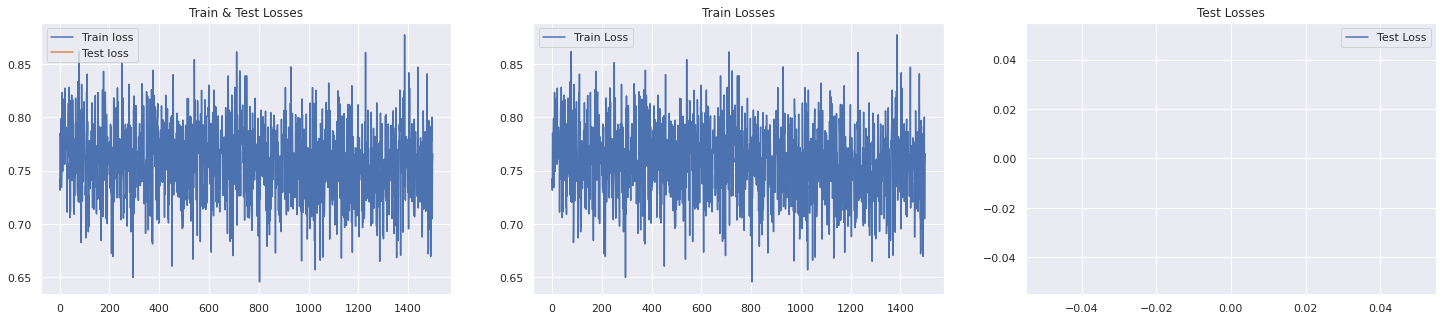

In [24]:
figure = plt.figure(figsize=(25,5))
labels = ['Loss Plots']

plt.subplot(1,3,1)
plt.title("Train & Test Losses")
plt.plot(train_loss_all,label='Train loss')
plt.plot(test_loss_all,label='Test loss')
plt.legend(loc="best")

plt.subplot(1,3,2)
plt.title("Train Losses")
plt.plot(train_loss_all,label='Train Loss')
plt.legend(loc="best")

plt.subplot(1,3,3)
plt.title("Test Losses")
plt.plot(test_loss_all,label='Test Loss')
plt.legend(loc="best")

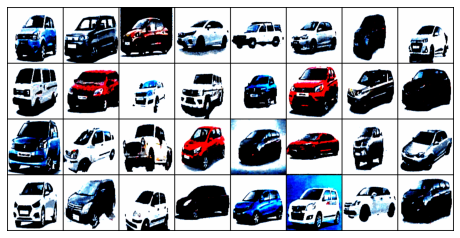

In [25]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_anim_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [26]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, metadata=dict(artist='Me'), bitrate=1800)
ani.save(f'/content/gdrive/My Drive/EVA4P2_S7_Training/animation_vae_v1.mp4', writer=writer)